In [1]:
from collections import OrderedDict
import numpy as np 
import matplotlib.pyplot as plt
import estaudel.heredity.deterministic as ehd
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

from multiprocessing import Pool
from functools import partial
import pickle
import scipy.optimize
import scipy.integrate

from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap

In [2]:
!mkdir supfig

mkdir: cannot create directory ‘supfig’: File exists


# Regimes

In [47]:
alist = [
         {'a0':.7, 'a1':.6, 'color':'C0','title':'internal'}, 
         {'a0':.7, 'a1':.7,'color':'C1','title':'perfect'},
         {'a0':.9, 'a1':.2,'color':'C2','title':'green'},
         {'a0':.4, 'a1':.8,'color':'C3','title':'red'},
         {'a0':.3, 'a1':.3,'color':'C4','title':'bistable'}
        ]

rholist = [(1.2,'redfast'),(0.8,'greenfast')] 
PARAMETERS = {
    'xstep':100,
    'tstep':100,

    'T':1,
    'K':1,

    'q':0.001,
    'r':50,
}
PARAMETERS['B'] = PARAMETERS['K']*PARAMETERS['q']

param = []
for a in alist:
    for rho,suptitle in rholist: 
        p = a.copy()
        p.update(PARAMETERS)
        p['title']+='_'+suptitle
        p['r'] = np.array([rho,1])*p['r']/p['T']
        p['rho'] = rho
        p['a'] = np.array([[p['a0'],1-p['a1']],
                            [1-p['a0'],p['a1']]])/p['K']
        param.append(p)
print('{} sets of parameters'.format(len(p)))


def lotka_volterra(x,t,r,a,**_):
    '''Temporal derivative of the LV system.'''
    return np.multiply(np.multiply(r,x),(1-np.dot(a,x)))


def lotka_volterra_Nf(x,t,r,a,**_):
    '''Temporal derivative of the LV system in Nf coordinates.
    x[0] = N, x[1] = f, return (dN/dt, df/dt)'''
    return np.array([
     (r[0]*(-a[0,0]*x[0]*x[1] + a[0,1]*(x[1] - 1)*x[0] + 1)*x[1] - r[1]*(x[1] - 1)*(-a[1,0]*x[0]*x[1] + a[1,1]*(x[1] - 1)*x[0] + 1))*x[0],
     (r[0]*(a[0,0]*x[0]*x[1] - a[0,1]*(x[1] - 1)*x[0] - 1) - r[1]*(a[1,0]*x[0]*x[1] - a[1,1]*(x[1] - 1)*x[0] - 1))*(x[1] - 1)*x[1]
    ])

def isocline_nontriviale_N(f,r,a):
    return (r[0]*f - r[1]*f + r[1])/(a[0,0]*r[0]*f**2 - a[0,1]*r[0]*f**2 + a[0,1]*r[0]*f - a[1,0]*r[1]*f**2 + a[1,0]*r[1]*f + a[1,1]*r[1]*f**2 - 2*a[1,1]*r[1]*f + a[1,1]*r[1])
def isocline_nontrivale_f(N,r,a):
    return (-a[0,1]*r[0]*N + a[1,1]*r[1]*N + r[0] - r[1])/((a[0,0]*r[0] - a[0,1]*r[0] - a[1,0]*r[1] + a[1,1]*r[1])*N)

13 sets of parameters


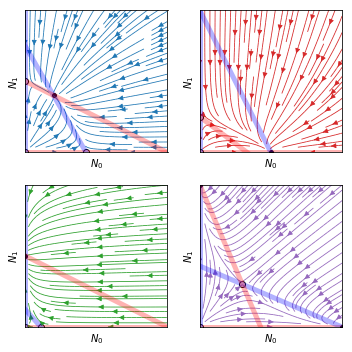

In [48]:
f, axes = plt.subplots(2,2,figsize=(5,5))


for p,ax in zip([param[x] for x in (0,6,4,8)],axes.flat):
    mx = np.max(1/p['a'])
    x = np.linspace(0,mx,20)
    X,Y = np.meshgrid(x,x)
    U = np.zeros_like(X)
    V = np.zeros_like(X)

    for i,(x,y) in enumerate(zip(X.flat,Y.flat)):
        U.flat[i],V.flat[i] = lotka_volterra(np.array([x,y]),t=0,**{k:p[k] for k in ('r','a')})
    ax.streamplot(X, Y, U, V,density=1, color=p['color'],linewidth=0.8)
    ax.set(xlabel='$N_0$',ylabel='$N_1$',
            xticks=[],yticks=[],
            xlim=(0,x.max()), ylim=(0,x.max()))
    
    ax.plot([0,mx],[0,0], color='r', ls='-',alpha=0.3,lw=5)
    ax.plot([0,0],[mx,0], color='b', ls='-',alpha=0.3,lw=5)

    # Isoclines non triviales 
    ax.plot([0,1/p['a'][0,0]], [1/p['a'][0,1],0], color='b', ls='-',alpha=0.3,lw=5)
    ax.plot([0,1/p['a'][1,0]],[1/p['a'][1,1],0], color='r', ls='-',alpha=0.3,lw=5)
    
    # Equilibria
    det = np.linalg.det(p['a'])
    internal = np.array([(p['a'][1,1]-p['a'][0,1])/det, (p['a'][0,0]-p['a'][1,0])/det])
    equilibria = [[0,0], [0,1/p['a'][1,1]], [1/p['a'][0,0],0]]
    stability = [False, p['a'][0,1]>p['a'][1,1], p['a'][1,0]>p['a'][0,0] ]
    if all(internal>0):
        equilibria.append(internal)
        stability.append(not stability[-1])
    stable_eq = [e for e,s in zip(equilibria, stability) if s]         
    for e,s in zip(equilibria, stability):
        ax.scatter(*e, color='k' if s else 'w', edgecolor='w' if s else 'k')

plt.tight_layout()
plt.savefig('supfig/paramspace_streamplot.pdf', bbox_inches='tight')

# Coordinates

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


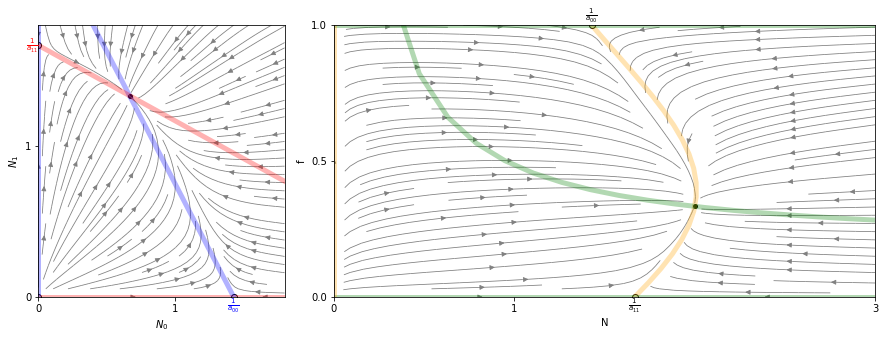

In [49]:
p = param[0] 
x = np.linspace(0,1.8,20)
plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan=2)

X,Y = np.meshgrid(x,x)
U = np.zeros_like(X)
V = np.zeros_like(X)
for i,(x,y) in enumerate(zip(X.flat,Y.flat)):
    U.flat[i],V.flat[i] = lotka_volterra(np.array([x,y]),t=0,**{k:p[k] for k in ('r','a')})
ax1.streamplot(X, Y, U, V,density=1.2, color='grey',linewidth=0.8)

# Isoclines triviales
mx = np.max(1/p['a'])
ax1.plot([0,mx],[0,0], color='r', ls='-',alpha=0.3,lw=5)
ax1.plot([0,0],[mx,0], color='b', ls='-',alpha=0.3,lw=5)

# Isoclines non triviales 
ax1.plot([0,1/p['a'][0,0]], [1/p['a'][0,1],0], color='b', ls='-',alpha=0.3,lw=5)
ax1.plot([0,1/p['a'][1,0]],[1/p['a'][1,1],0], color='r', ls='-',alpha=0.3,lw=5)
ax1.text(1/p['a'][0,0], 0, r'$\frac{1}{a_{00}}$', color='b',
        horizontalalignment='center', verticalalignment='top')
ax1.text(0, 1/p['a'][1,1], r'$\frac{1}{a_{11}}$', color='r',
        horizontalalignment='right', verticalalignment='center')

det = np.linalg.det(p['a'])
internal = np.array([(p['a'][1,1]-p['a'][0,1])/det, (p['a'][0,0]-p['a'][1,0])/det])
equilibria = [[0,0], [0,1/p['a'][1,1]], [1/p['a'][0,0],0]]
stability = [False, p['a'][0,1]>p['a'][1,1], p['a'][1,0]>p['a'][0,0] ]
if all(internal>0):
    equilibria.append(internal)
    stability.append(not stability[-1])
stable_eq = [e for e,s in zip(equilibria, stability) if s]         
for e,s in zip(equilibria, stability):
    ax1.scatter(*e, color='k' if s else 'w', edgecolor='w' if s else 'k')
    if np.sum(e):
        ax2.scatter(np.sum(e),e[0]/np.sum(e), color='k' if s else 'w', edgecolor='w' if s else 'k')
ax1.set(xlabel='$N_0$',ylabel='$N_1$',
        xticks=[0,1],yticks=[0,1],
        xlim=(0,x.max()),
        ylim=(0,x.max()))
        
y = np.linspace(0,1,20)
x = np.linspace(0,3,20)

ntN = isocline_nontriviale_N(y, p['r'],p['a'])
ax2.plot(ntN,y,color='orange', ls='-',alpha=0.3,lw=5)

ntf = isocline_nontrivale_f(x, p['r'],p['a'])
ax2.plot(x,ntf,color='green', ls='-',alpha=0.3,lw=5)
    
ax2.plot([0,x.max()],[0,0], color='g', ls='-',alpha=0.3,lw=5)
ax2.plot([0,x.max()],[1,1], color='g', ls='-',alpha=0.3,lw=5)
ax2.plot([0,0],[0,1], color='orange', ls='-',alpha=0.3,lw=5)

ax2.text(1/p['a'][0,0], 1, r'$\frac{1}{a_{00}}$', color='k',
        horizontalalignment='center', verticalalignment='bottom')
ax2.text(1/p['a'][1,1], 0, r'$\frac{1}{a_{11}}$', color='k',
        horizontalalignment='center', verticalalignment='top')


X,Y = np.meshgrid(x,y)
U = np.zeros_like(X)
V = np.zeros_like(X)
for i,(x,y) in enumerate(zip(X.flat,Y.flat)):
    U.flat[i],V.flat[i] = lotka_volterra_Nf(np.array([x,y]),t=0,**{k:p[k] for k in ('r','a')})
ax2.streamplot(X, Y, U, V,density=1.2, color='grey',linewidth=0.8)
ax2.set(xlabel='N',ylabel='f',ylim=(0,y.max()), xlim=(0,x.max()),xticks=[0,1,3],yticks=[0,0.5,1])
plt.savefig('supfig/nf_coordinate_streamplot.pdf',bbox_inches='tight')

# Bifurcation diagrams

In [50]:
param

[{'B': 0.001, 'K': 1, 'T': 1, 'a': array([[0.7, 0.4],
         [0.3, 0.6]]), 'a0': 0.7, 'a1': 0.6, 'color': 'C0', 'q': 0.001, 'r': array([60., 50.]), 'rho': 1.2, 'title': 'internal_redfast', 'tstep': 100, 'xstep': 100},
 {'B': 0.001, 'K': 1, 'T': 1, 'a': array([[0.7, 0.4],
         [0.3, 0.6]]), 'a0': 0.7, 'a1': 0.6, 'color': 'C0', 'q': 0.001, 'r': array([40., 50.]), 'rho': 0.8, 'title': 'internal_greenfast', 'tstep': 100, 'xstep': 100},
 {'B': 0.001, 'K': 1, 'T': 1, 'a': array([[0.7, 0.3],
         [0.3, 0.7]]), 'a0': 0.7, 'a1': 0.7, 'color': 'C1', 'q': 0.001, 'r': array([60., 50.]), 'rho': 1.2, 'title': 'perfect_redfast', 'tstep': 100, 'xstep': 100},
 {'B': 0.001, 'K': 1, 'T': 1, 'a': array([[0.7, 0.3],
         [0.3, 0.7]]), 'a0': 0.7, 'a1': 0.7, 'color': 'C1', 'q': 0.001, 'r': array([40., 50.]), 'rho': 0.8, 'title': 'perfect_greenfast', 'tstep': 100, 'xstep': 100},
 {'B': 0.001, 'K': 1, 'T': 1, 'a': array([[0.9, 0.8],
         [0.1, 0.2]]), 'a0': 0.9, 'a1': 0.2, 'color': 'C2', 'q':

/home/guilhem/.local/lib/python3.5/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


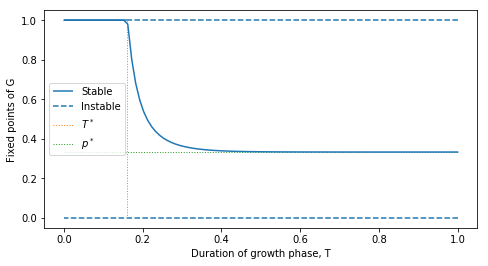

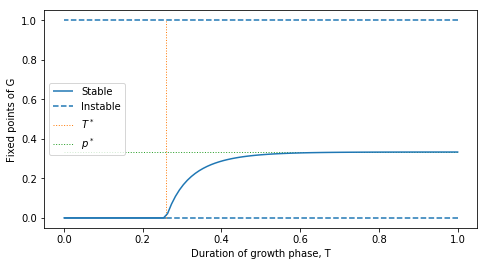

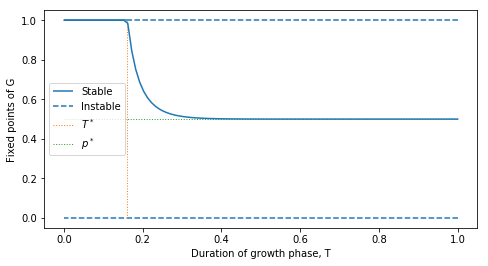

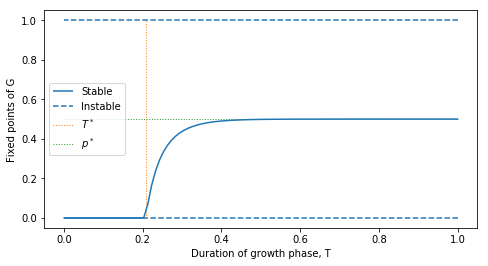

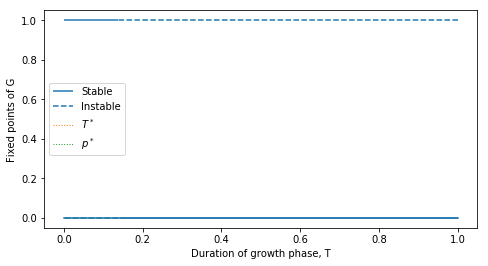

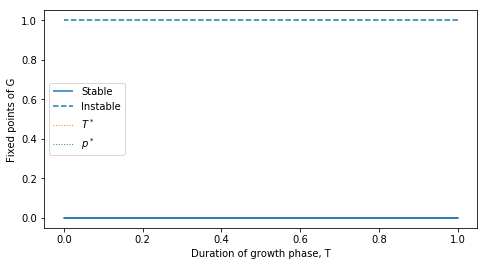

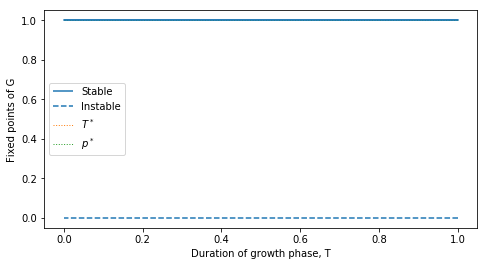

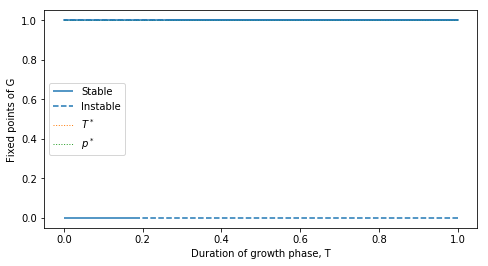

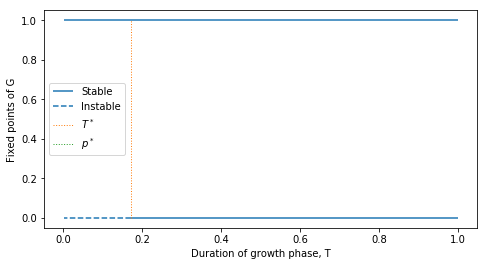

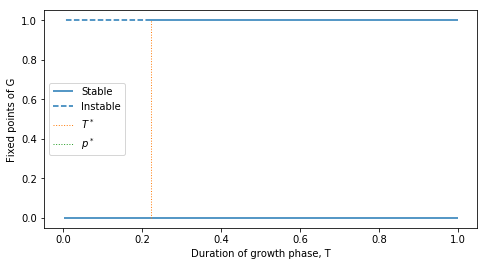

In [57]:
xstep = 100
tstep = 100

T = 1
K = 1

q = 0.001
r = 50
rho = 1.2

a0 = .53
a1 = .6

B = K*q
r = np.array([rho,1])*r/T
a = np.array([[a0,1-a1],
              [1-a0,a1]])/K
rholist = [1.2,0.8] 
data = []
for i,p in enumerate(alist):
    for rho in rholist:
        data.append({'rho':rho,'q':q,'param':p,'r':r})
        
j = 0
for i,p in enumerate(alist):
    for rho in rholist:
        T = 1
        K = 1
        r = 50
        q = 0.001
        tstep = 1000
        
        
        
        B = K*q
        r = np.array([rho,1])*r/T
        A = np.array([[p['a0'],1-p['a1']],
          [1-p['a0'],p['a1']]])/K
        data[j][''] = 0
        asymptotic_pstar = ehd.pstar(A)
        g = ehd.get_gfunc(r,A,B)
        data[j]['t'],data[j]['pstar'] = ehd.continuation_on_T(g, t0=1, tf=1e-3, start=asymptotic_pstar)
        data[j]['stab'] = ehd.stability_of_01(g, t0=1, tf=1e-3)
        data[j]['tstar'] = ehd.tstar(r, A, B, precise=True)
        j+=1

/home/guilhem/.local/lib/python3.5/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


NameError: name 'get_segments' is not defined

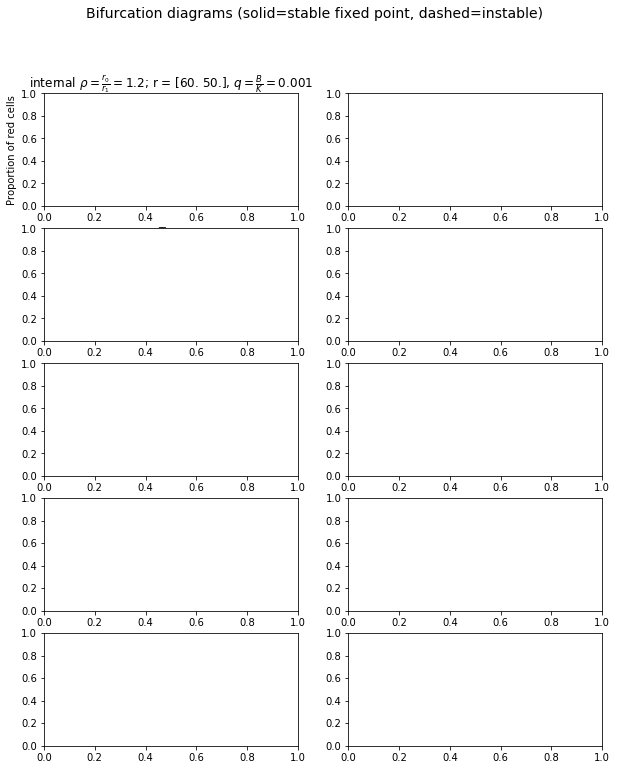

In [56]:
f,axes = plt.subplots(5,2,figsize=(10,12))
st = f.suptitle("Bifurcation diagrams (solid=stable fixed point, dashed=instable)", fontsize=14)

#st.set_y(0.95)
for i,d in enumerate(data):
    ax = axes.flatten()[i]
    color = d['param']['color']
    ax.set(title=d['param']['title'] + r' $\rho=\frac{{r_0}}{{r_1}}={}$; r = {}, $q =\frac{{B}}{{K}}={} $'.format(d['rho']
                                                                                                                  ,d['r'],
                                                                                                                  d['q']),
                        xlabel='Time', xlim=(0,1),
                        ylabel='Proportion of red cells')
    
    for ((t0,t1),val) in get_segments(d['stable_internal']):
        ax.plot(d['time'][t0:t1],d['roots'][t0:t1], 
                color=color, linestyle={False:':',True:'-'}[val])
    for ((t0,t1),val) in get_segments(d['stable_0']):
        ax.plot([d['stable_time'][t0],d['stable_time'][t1-1]],[0,0],
                color=color, linestyle={False:':',True:'-'}[val])
    for ((t0,t1),val) in get_segments(d['stable_1']):
        ax.plot([d['stable_time'][t0],d['stable_time'][t1-1]],[1,1],
                color=color, linestyle={False:':',True:'-'}[val])    
        
    ax.grid(alpha=.1)
plt.tight_layout()
f.subplots_adjust(top=0.93)
f.savefig('bifurcation_diagrams.png',bbox_inches='tight')

In [ ]:
for p in param:
    A = p['a']
    B = p['B']
    r = p['r']
    asymptotic_pstar = ehd.pstar(A)
    g = ehd.get_gfunc(r,A,B)
    t,pstar = ehd.continuation_on_T(g, t0=1, tf=1e-3, start=asymptotic_pstar)
    stab = ehd.stability_of_01(g, t0=1, tf=1e-3)
    tstar = ehd.tstar(r, A, B, precise=True)

    fig = plt.figure(figsize=(12,4))
    ax = plt.subplot2grid((1,3),(0,0),1,2)
    for k,v in stab.items():
        for seg in v:
            ax.hlines(k,seg[1][0],seg[1][1],
                      linestyles='-' if seg[0] else '--',
                      color='C0',
                      label='Stable' if seg[0] else 'Instable')


    ax.vlines(tstar,0,1, linestyles=':', lw=1,color='C1', label='$T^*$')
    ax.hlines(asymptotic_pstar,0,1, linestyles=':',lw=1, color='C2', label='$p^*$')


    ax.plot(t,pstar, color='C0',label='Stable')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='center left')
    ax.set(ylabel='Fixed points of G', xlabel='Duration of growth phase, T')

# T*

# p*

In [12]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

import numpy as np
import estaudel.escaffolding as escaffolding
import estaudel.heredity.process
from collections import Counter
import estaudel.heredity.deterministic

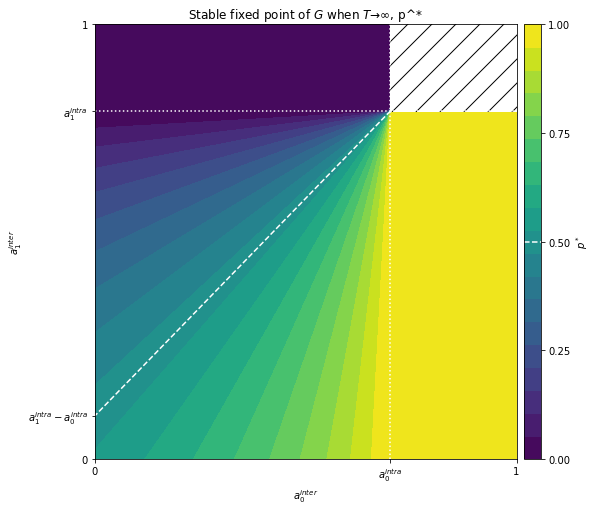

In [58]:
xx = np.linspace(0,1,200)
Xa,Ya = np.meshgrid(xx,xx)
a0 = 0.7
a1 = 0.8
f = np.vectorize(lambda x,y: estaudel.heredity.deterministic.pstar(np.array([[a0,y],
                                                                             [x,a1]])))
Za = f(Xa,Ya)

ticks = [0,0.25,0.5,0.75,1]
levels = np.linspace(0,1,20)

fig, ax = plt.subplots(1,1, figsize=(8,8))
cax = make_axes_locatable(ax).append_axes("right", size="4%", pad=0.11)

# Background 
im = ax.contourf(Xa, Ya, Za, cmap='viridis', levels=levels)
ax.contourf(Xa, Ya, np.int_(np.isnan(Za)), colors='white', levels=[0.1,1],  hatches='/') 
ax.contour(Xa,Ya,Za,colors='w',linestyles='--',levels=[0.5])

# Colorbar
fig.colorbar(im, cax=cax, ticks=ticks,
             label=r'$p^*$')
cax.hlines(0.5,0,1,color='w',linestyles='--')
ax.hlines(a1,0,1,color='w',linestyles=':')
ax.vlines(a0,0,1,color='w',linestyles=':')


# Set axis
ax.set(
        xlabel=r'$a_0^{inter}$', 
        ylabel=r'$a_1^{inter}$',
        title=r'Stable fixed point of $G$ when $T \to \infty$, p^*',
        xlim=(Xa[0,0],Xa[-1,-1]),
        ylim=(Ya[0,0],Ya[-1,-1]),
        xticks=[0,a0,1],
        xticklabels=[0,'$a_0^{intra}}$',1,],
        yticklabels=[0, '$a_1^{intra}-a_0^{intra}$','$a_1^{intra}$',1,],
        yticks=[0,a1-a0,a1,1]
);

plt.savefig('supfig/position_of_pstar.pdf',bbox_inches='tight')